# Comparing grbsens and ctools

In [7]:

import logging
import random
from pathlib import Path

import astropy.units as u

# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import fits
from gammapy.modeling.models import PowerLawSpectralModel
from scipy import integrate
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.optimize import brentq
from tqdm import tqdm

from gravitational_wave_toy.ctairf import IRFHouse
from gravitational_wave_toy.observe import GRB, oGRB
from gravitational_wave_toy.sensitivity import SensitivityCtools, SensitivityGammapy, gamma_sens
from gravitational_wave_toy.util import suppress_warnings_and_logs

sns.set()
    
# set logging level to debug
# logging.basicConfig(level=logging.DEBUG)


### Load in IRF (South Alpha z20 prod5-v0.1)

In [17]:
house = IRFHouse(base_directory="/Users/jarred/Documents/Work/CTA-IRFs")

site = "south"
configuration = "alpha"
zenith = 20

irf = house.get_irf(
    site=site,
    configuration=configuration,
    zenith=zenith,
    duration=1800,
    azimuth="average",
    version="prod5-v0.1" if configuration == "alpha" else "prod3b-v2",
)

### Load in ctools sensitivity
- direct from file, no fitting atm

In [19]:
grbsens_dir = Path(
    f"/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/{configuration}_configuration"
)
file = (
    grbsens_dir
    / f"grbsens-5.0sigma_t1s-t16384s_irf-{irf.site.name.capitalize()}_z{irf.zenith}_0.5h.txt"
)
cols = [
    "duration",
    "crab_flux",
    "photon_flux",
    "energy_flux",
    "sensitivity",
]

ctools_curve = pd.read_csv(file, sep="\t", comment="#", names=cols)

### Load in gammapy sensitivity
- first try with a fixed power law modela

In [57]:
times = ctools_curve.duration.to_numpy()
tables = {}
gammapy_res = {}

model = PowerLawSpectralModel(
    index=2.1, amplitude="5.7e-13 cm-2 s-1 TeV-1", reference="1 TeV"
)

for duration in tqdm(
    times,
    desc=f"Processing IRF: {irf.version} {irf.site} {irf.zenith}deg {irf.duration}s",
):
    with suppress_warnings_and_logs():
        s = gamma_sens(
            irf=irf.filepath,
            observatory=f"cta_{irf.site.name}",
            duration=duration * u.s,
            model=model,
            radius=3.0 * u.deg,
            min_energy=0.03 * u.TeV,
            max_energy=10 * u.TeV,
            sigma=5,
            bins=1,
            offset=0.0,
        )

    tables[duration] = s
    gammapy_res[duration] = s["e2dnde"][0]

Processing IRF: prod5-v0.1 Site.south 20deg 1800s: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


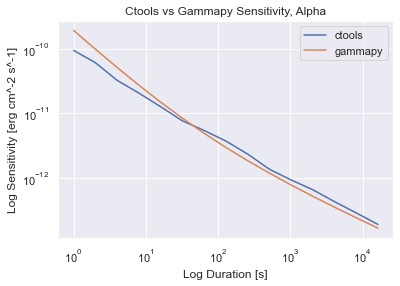

In [58]:
plt.loglog(ctools_curve["duration"], ctools_curve["sensitivity"], label="ctools")
plt.loglog(tables.keys(), gammapy_res.values(), label="gammapy")
plt.legend()
plt.xlabel("Log Duration [s]")
plt.ylabel("Log Sensitivity [erg cm^-2 s^-1]")
plt.title("Ctools vs Gammapy Sensitivity, Alpha")
plt.show()

## Using the varying power law of ctools with gammapy

In [22]:
ctools_integral_models = pd.read_csv(
    "./integral-models.csv"
)

In [26]:
ctools_integral_models

,duration,loge,emin,emax,crab_flux,photon_flux,energy_flux,sensitivity,regcoeff,nevents,...,model_index,model_index_error,model_pivot,model_pivot_error,background_prefactor,background_prefactor_error,background_index,background_index_error,background_pivot,background_pivot_error
0,1,-0.261439,0.03,10.0,0.676036,2.358434e-09,5.503451e-10,9.341863e-11,0.776313,237.0,...,-2.1,0,1000,0,1.152548,0.225744,0.004069,0.079323,1000000,0
1,2,-0.261439,0.03,10.0,0.436580,1.523064e-09,3.554098e-10,6.032924e-11,0.975347,421.0,...,-2.1,0,1000,0,1.009064,0.163514,-0.000221,0.066225,1000000,0
2,4,-0.261439,0.03,10.0,0.232798,8.121433e-10,1.895152e-10,3.216936e-11,0.962125,847.0,...,-2.1,0,1000,0,0.923630,0.104054,-0.044389,0.045438,1000000,0
3,8,-0.261439,0.03,10.0,0.147558,5.147754e-10,1.201238e-10,2.039048e-11,0.960469,1668.0,...,-2.1,0,1000,0,1.048266,0.075537,0.016947,0.029204,1000000,0
4,16,-0.261439,0.03,10.0,0.090753,3.166028e-10,7.387986e-11,1.254078e-11,0.958654,3448.0,...,-2.1,0,1000,0,1.099384,0.054963,0.021804,0.020283,1000000,0
5,32,-0.261439,0.03,10.0,0.054726,1.909183e-10,4.455114e-11,7.562358e-12,0.982807,6741.0,...,-2.1,0,1000,0,1.060713,0.038467,0.015847,0.014717,1000000,0
6,64,-0.261439,0.03,10.0,0.038860,1.355666e-10,3.163473e-11,5.369856e-12,0.988464,13322.0,...,-2.1,0,1000,0,1.019267,0.026643,0.003942,0.010586,1000000,0
7,128,-0.261439,0.03,10.0,0.026641,9.293926e-11,2.168755e-11,3.681366e-12,0.962125,26272.0,...,-2.1,0,1000,0,0.987388,0.018329,-0.003763,0.007499,1000000,0
8,256,-0.261439,0.03,10.0,0.016765,5.848734e-11,1.364813e-11,2.316710e-12,0.996443,52711.0,...,-2.1,0,1000,0,0.990883,0.013085,-0.003891,0.005339,1000000,0
9,512,-0.261439,0.03,10.0,0.009749,3.400908e-11,7.936083e-12,1.347115e-12,0.999903,105508.0,...,-2.1,0,1000,0,0.997151,0.009291,-0.001546,0.003769,1000000,0


In [45]:
tables = {}
tables_upper = {}
tables_lower = {}
gammapy_res = {}
gammapy_res_upper = {}
gammapy_res_lower = {}

for row in tqdm(
    ctools_integral_models.itertuples(),
    desc=f"Processing IRF: {irf.version} {irf.site} {irf.zenith}deg {irf.duration}s",
):
    
    duration = row.duration
    index = row.model_index * -1
    amplitude = row.model_prefactor * u.Unit("cm-2 s-1 MeV-1")
    amplitude_error = row.model_prefactor_error * u.Unit("cm-2 s-1 MeV-1")
    reference = row.model_pivot * u.GeV
    
    model = PowerLawSpectralModel(
        index=index, amplitude=amplitude, reference=reference
    )
    
    model_upper = PowerLawSpectralModel(
        index=index, amplitude=amplitude + amplitude_error, reference=reference
    )
    
    model_lower = PowerLawSpectralModel(
        index=index, amplitude=amplitude - amplitude_error, reference=reference
    )
    
    
    # print(duration, amplitude, amplitude - amplitude_error, amplitude + amplitude_error)
    
    with suppress_warnings_and_logs():
        s = gamma_sens(
            irf=irf.filepath,
            observatory=f"cta_{irf.site.name}",
            duration=duration * u.s,
            model=model,
            radius=3.0 * u.deg,
            min_energy=0.03 * u.TeV,
            max_energy=10 * u.TeV,
            sigma=5,
            bins=1,
            offset=0.0,
        )
        
        s_upper = gamma_sens(
            irf=irf.filepath,
            observatory=f"cta_{irf.site.name}",
            duration=duration * u.s,
            model=model_upper,
            radius=3.0 * u.deg,
            min_energy=0.03 * u.TeV,
            max_energy=10 * u.TeV,
            sigma=5,
            bins=1,
            offset=0.0,
        )
        
        s_lower = gamma_sens(
            irf=irf.filepath,
            observatory=f"cta_{irf.site.name}",
            duration=duration * u.s,
            model=model_lower,
            radius=3.0 * u.deg,
            min_energy=0.03 * u.TeV,
            max_energy=10 * u.TeV,
            sigma=5,
            bins=1,
            offset=0.0,
        )
        

    tables[duration] = s
    tables_upper[duration] = s_upper
    tables_lower[duration] = s_lower
    gammapy_res[duration] = s["e2dnde"][0]
    gammapy_res_upper[duration] = s_upper["e2dnde"][0]
    gammapy_res_lower[duration] = s_lower["e2dnde"][0]

Processing IRF: prod5-v0.1 Site.south 20deg 1800s: 0it [00:00, ?it/s]

Processing IRF: prod5-v0.1 Site.south 20deg 1800s: 14it [00:08,  1.62it/s]


In [43]:
for duration in tables.keys():
    
    print(gammapy_res_lower[duration], gammapy_res[duration], gammapy_res_upper[duration])

1.9076699157273914e-10 1.9076699157273914e-10 1.9076699157273916e-10
9.780167673976826e-11 9.780167673976826e-11 9.780167673976824e-11
5.089299097060497e-11 5.0892990970605005e-11 5.089299097060498e-11
2.704364802556176e-11 2.7043648025561752e-11 2.7043648025561768e-11
1.4765864947623665e-11 1.4765864947623662e-11 1.4765864947623662e-11
8.325038404837797e-12 8.325038404837794e-12 8.325038404837797e-12
4.858617515600368e-12 4.858617515600366e-12 4.858617515600366e-12
2.9339750432210044e-12 2.9339750432210036e-12 2.9339750432210044e-12
1.828249858353898e-12 1.8282498583538985e-12 1.828249858353898e-12
1.1708443953577063e-12 1.1708443953577063e-12 1.1708443953577059e-12
7.671974038411537e-13 7.671974038411535e-13 7.671974038411531e-13
3.4690086154435583e-13 3.4690086154435604e-13 3.4690086154435583e-13
2.376546253014042e-13 2.3765462530140403e-13 2.376546253014042e-13
1.6421191707849158e-13 1.642119170784916e-13 1.6421191707849163e-13


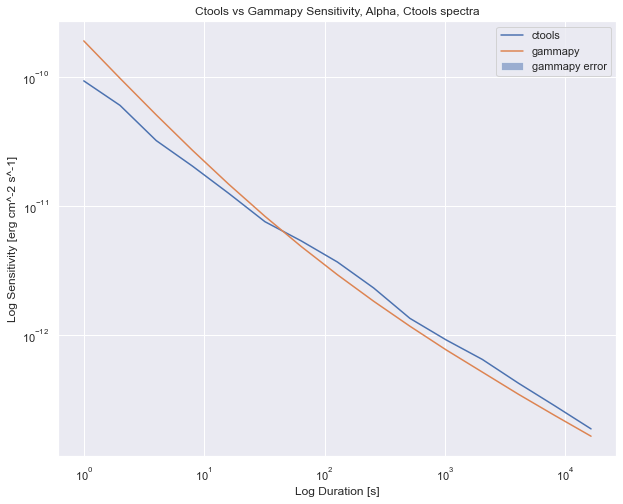

In [47]:
plt.figure(figsize=(10, 8))
plt.loglog(ctools_curve["duration"], ctools_curve["sensitivity"], label="ctools")
plt.loglog(tables.keys(), gammapy_res.values(), label="gammapy")
plt.fill_between(
    tables.keys(),
    np.log10(list(gammapy_res_lower.values())),
    np.log10(list(gammapy_res_upper.values())),
    alpha=0.5,
    label="gammapy error",
)
plt.title("Ctools vs Gammapy Sensitivity, Alpha, Ctools spectra")
plt.xlabel("Log Duration [s]")
plt.ylabel("Log Sensitivity [erg cm^-2 s^-1]")
plt.legend()
plt.show()

In [59]:
tables[16]

energy,e_ref,e_min,e_max,e2dnde,excess,background,criterion
TeV,TeV,TeV,TeV,erg / (s cm2),,,
float64,float64,float64,float64,float64,float64,float64,bytes12
0.547723,0.547723,0.03,10,1.47659e-11,8.95258,0.30099,significance
